# Gibbs Sampler para los modelos hard-core y q-coloring


Autores: 
- Daniel Alejandro García Hernández
- David Camilo Cortes Salazar

En este notebook se encuentra una implementación del Gibbs Sampler para Hard-core y q-colorings. 

Las librerías necesarias para ejectuar el código son:

In [19]:
import random
import numpy as np
import networkx as nx
from copy import deepcopy
import matplotlib.pyplot as plt

---
# Punto 3 - Gibbs Sampler para las q-coloraciones (q-colorings)

Iniciamos definiendo algunas funciones que ya habían sido usadas en el programa anterior.


Acto seguido, creamos la grilla del módelo. Para esto, usamos un grafo cuadrado 2D de NetworkX con colores que siguen una diagonal, asegurando así que el estado inicial es una q-coloración válida. 


Este grafo recibe de input las dimensiones $k$ del grafo, y el número $q$ de colores. Se tiene las condiciones:

- $3\leq k \leq 20$,
- $2\leq q \leq 10$.

Los colores ya se encuentran en el código, por lo que no es necesario que el usuario los ingrese.

In [26]:
def restart_G(k, q, colors_list):
    """
    Hallar y reiniciar el valor del grafo y el color de los nodos
    :param k: Dimensions of the lattice 
    :param q: Number of colors
    :param colors_list: Listas de colores
    :return: Grafo de networkx con forma de lattice cuadrado y el valor inicial de los colores tal que es q-coloracion
    """
    G = nx.grid_2d_graph(k, k)
    color_values = {node: colors_list[(i + i//k - (i//k)*k)%q] for i, node in enumerate(G.nodes())}
    
    return G, color_values


    
def plot_grid(G, color_values):
    """
    Grafica el grafo, con el color de los nodos dados
    :param G: Grafo de networkx 
    :param color_values: Valor de colores de los nodos del grafo
    :return: 
    """
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    options = {
        "font_size": 200,
        "node_size": int(30000/k**2),
        "edgecolors": "black",
        "linewidths": 1.7,
        "width": 1.7,
        "with_labels": False,
        "node_color": color_values.values(),
    }

    plt.figure(figsize=(5 + 0.1*k, 5 + 0.1*k))
    nx.draw_networkx(G, pos=pos, **options)
    plt.tight_layout()
    plt.show()
    

    
def find_vecinos_dict():
    """
    Funcion experimental para acelerar el codigo. De momento no se usa
    :return: 
    """
    vecinos = {}

    for x in range (0, k):
        for y in range (0, k):
            vecinos[(x, y)] = G.neighbors((x,y))
    
    return vecinos


    
def find_valid_colors(G, color_values, x, y):
    colores_vecinos = set()
    
    for vecino in G.neighbors((x,y)):
        colores_vecinos.add(color_values[vecino])
    
    valid_colors = list(set(colors_list) - colores_vecinos)
    
    return valid_colors    
    
    
    
def random_step(G, color_values):
    x = random.choice(range(0,k))
    y = random.choice(range(0,k))
      
    valid_colors = find_valid_colors(G, color_values, x, y)
    new_color = random.choice(valid_colors)
    color_values[(x,y)] = new_color
    
    return color_values
    

    
def find_random_evolution(G, color_values, n):
    for _ in range(n): 
        color_values = random_step(G, color_values)
        
    return color_values
        
        

def systematic_step(G, color_values, x, y):
    valid_colors = find_valid_colors(G, color_values, x, y)
    new_color = random.choice(valid_colors)
    color_values[(x,y)] = new_color
    
    return color_values
    

    
def find_systematic_evolution(G, color_values, n):
    for ii in range(n): 
        x = ii % k
        y = (ii//k) % k
        color_values = systematic_step(G, color_values, x, y)
        
    return color_values
    
    
def calculate_number_simulations(epsilon, d=4):
    top = 48 * (d**3) * k**3
    bot = epsilon**2
    return top/bot
    
    
def calculate_number_gibbs_steps(epsilon, d=4):
    top = 2*np.log(k) + np.log(1/epsilon) + np.log(8)
    bot = np.log(q / (2*d))
    ans = k*(top/bot + 1)
    return ans


def find_Gj(G, j):
    edges = list(G.edges)
    edges_to_remove = edges[j+1 : len(edges)]
    Gj = deepcopy(G)
    
    for edge_to_remove in edges_to_remove:
        Gj.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
    return Gj


def find_ej(G, j):
    edges = list(G.edges)
    e_j = edges[j]
    
    return e_j


def estimate_q_colorings(k, q, epsilon, colors_list=None):    
    if colors_list is None:
        colors_list = ["red", "blue", "green", "orange", "grey", "purple", "black", "magenta", "white", "cyan"]
        
    n_simulations = 1000 # FALTA. Debe calcularse con la funcion de arriba
    n_gibbs_steps = 100*k*k # FALTA. DEbe calcularse con la funcion de arriba
    
    q_colorings = q**(k*k)

    G, color_values = restart_G(k, q, colors_list)    
    for j in range(1, len(list(G.edges()))):
        rho_j_1 = 0
        e_j = find_ej(G, j) # Edge which is in G_{j} but not in G_{j−1}
            
        for ii in range (n_simulations):
            G, color_values = restart_G(k, q, colors_list)    
            G_j_1 = find_Gj(G, j-1)
            color_values = find_systematic_evolution(G_j_1, color_values, n_gibbs_steps)
            rho_j_1 += int(color_values[e_j[0]] != color_values[e_j[1]])
        
        rho_j_1 = rho_j_1 / n_simulations
        q_colorings *= rho_j_1
    
    return q_colorings


def estimate_q_colorings_multiple_runs(k, q, epsilon, num_runs):
    q_colorings = []
    
    for _ in range(num_runs):
        new_value = estimate_q_colorings(k, q, epsilon)
        q_colorings.append(new_value)
    
    avg = np.average(q_colorings)
    std = np.std(q_colorings)
    
    return avg, std

def print_q_colorings(k, q, epsilon, avg, std):
    print(f'k Dimension del lattice: {k}')
    print(f'q Numero de colores: {q}')
    print(f'epsilon de la funcion: {epsilon}')
    print(f'Numero de q-coloraciones : {avg:.1f}', u"\u00B1", f'{std:.1f}')

In [3]:
print(calculate_number_gibbs_steps(0.5))
print(calculate_number_simulations(0.5))

NameError: name 'k' is not defined

Ahora, definimos los inputs del programa, y graficamos ver el grafo y la q-coloracion inicial

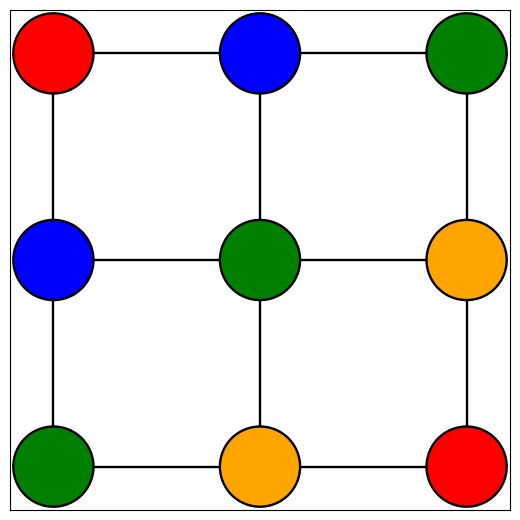

In [4]:
## Inputs del programa    
"""
k: Dimensiones del lattice kxk
q: Numero de colores
d: Maximo numero de vecinos de algun nodo
"""

k = 3
q = 4

## Lista de colores preestablecidos. Se usaran los primeros q
colors_list = ["red", "blue", "green", "orange", "grey", "purple", "black", "magenta", "white", "cyan"]


# Iniciar el valor de los colores
colors_list = colors_list[:q:]
G, color_values = restart_G(k, q, colors_list)
#vecinos = find_vecinos_dict()


# Graficar la grilla
plot_grid(G, color_values)

Graficamos $G_{j-1}$ y $G_{j}$. Miramos el enlace $e_{j}$, y verificamos si los colroes son diferentes

e_j =  ((1, 0), (1, 1))
Color de los nodos de e_j: blue green
Son diferentes?: True

G_{j-1}:


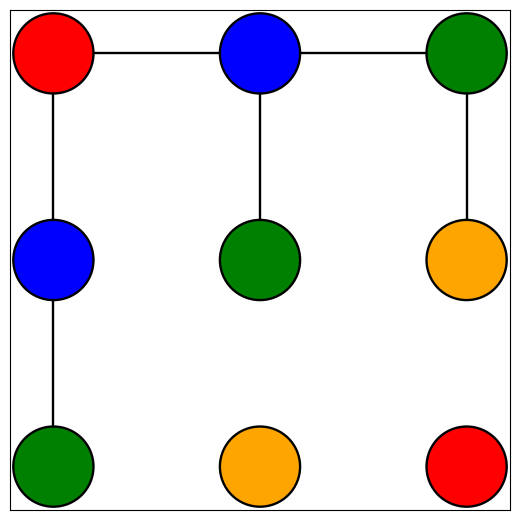




G_{j}:


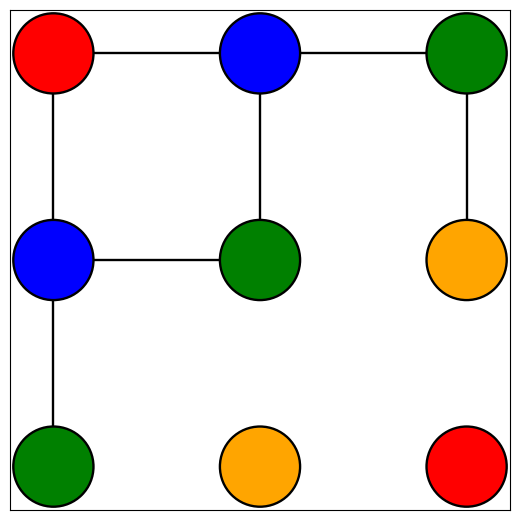

In [12]:
G, color_values = restart_G(k, q, colors_list)

counter_they_are_equal = 0

j = 6

e_j = find_ej(G, j)

G_j_1 = find_Gj(G, j-1)

color_values = find_systematic_evolution(G_j_1, color_values, 1)

print('e_j = ',  e_j)
print('Color de los nodos de e_j:', color_values[e_j[0]], color_values[e_j[1]])
print(f'Son diferentes?: {color_values[e_j[0]] != color_values[e_j[1]]}')


print("\nG_{j-1}:")
plot_grid(G_j_1, color_values)


## Verificacion. Grafica de G_j. Sirve para comparar con G_j_1 y ver el indice e_j
G_j = deepcopy(G_j_1)
G_j.add_edge(e_j[0], e_j[1])
print("\n\n\nG_{j}:")
plot_grid(G_j, color_values)

Corremos varias veces la simulacio. (¿Será que borramos esta celda?)

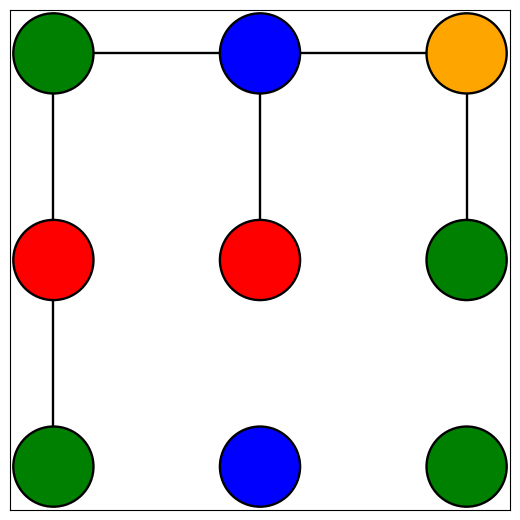

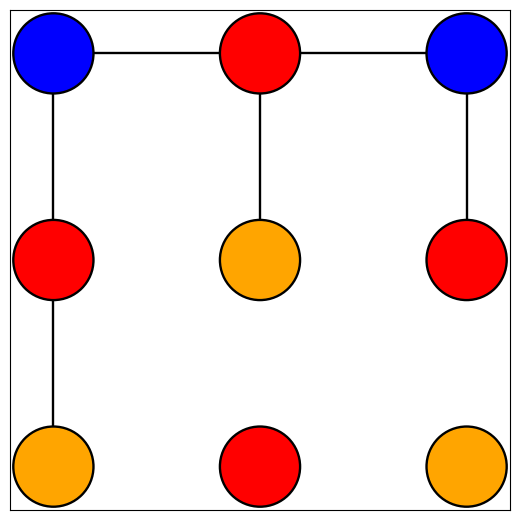

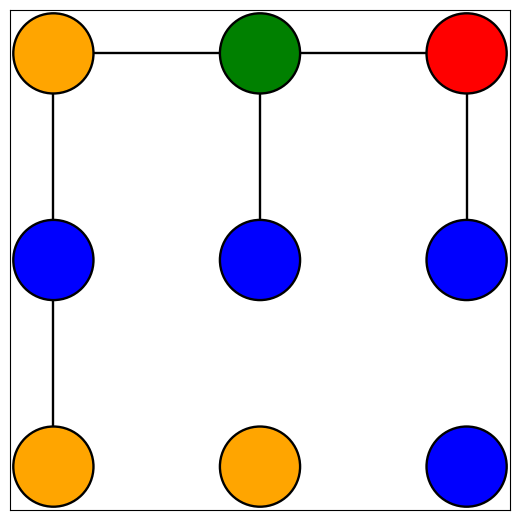

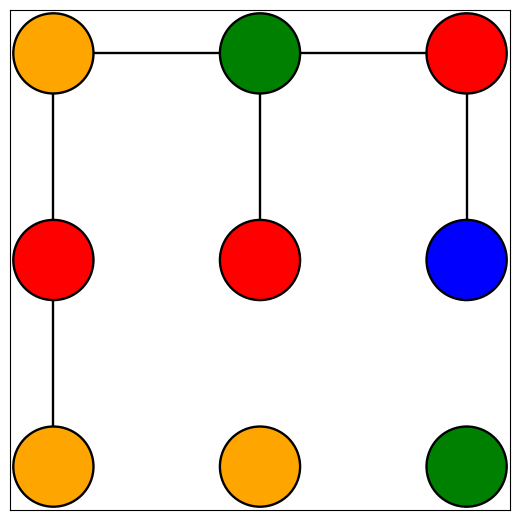

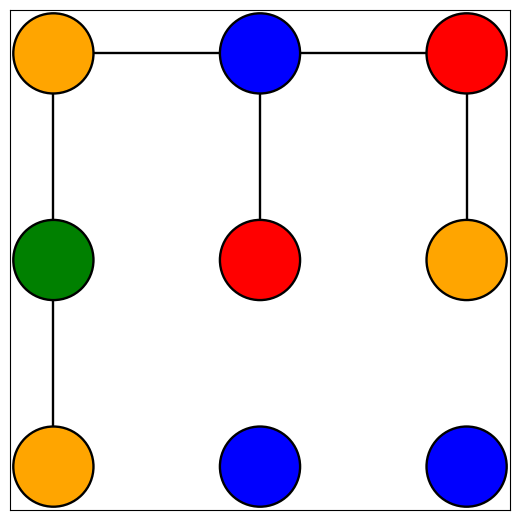

Proporcion de simulaciones de q-coloraciones de G_{j-1} en la que la cara y la cola de e_j tienen colores diferentes: 0.4


In [15]:
n_gibbs_steps = 100*k*k
n_simulations = 5
rho_j_1 = 0
j = 6

e_j = find_ej(G, j)

for ii in range (n_simulations):
    G, color_values = restart_G(k, q, colors_list)    

    G_j_1 = find_Gj(G, j-1)
        
    color_values = find_systematic_evolution(G_j_1, color_values, n_gibbs_steps)

    rho_j_1 += int(color_values[e_j[0]] != color_values[e_j[1]])
    
    plot_grid(G_j_1, color_values)

rho_j_1 = rho_j_1 / n_simulations


print('Proporcion de simulaciones de q-coloraciones de G_{j-1} en la que la cara y la cola de e_j tienen colores diferentes:', rho_j_1)

In [16]:
n_simulations = 1000
n_gibbs_steps = 100*k*k

q_colorings = q**(k*k)

G, color_values = restart_G(k, q, colors_list)    

for j in range(1, len(list(G.edges()))):
    rho_j_1 = 0
    e_j = find_ej(G, j) # Edge which is in G_{j} but not in G_{j−1}
        
    for ii in range (n_simulations):
        G, color_values = restart_G(k, q, colors_list)    

        G_j_1 = find_Gj(G, j-1)
            
        color_values = find_systematic_evolution(G_j_1, color_values, n_gibbs_steps)
    
        rho_j_1 += int(color_values[e_j[0]] != color_values[e_j[1]])
    
    rho_j_1 = rho_j_1 / n_simulations
    q_colorings *= rho_j_1

print(q_colorings)

13553.79238967955


Ahora, insertamos todo esto en una unica funcion

In [31]:
k = 3
q = 4
epsilon = 0.1
num_runs = 2

avg, std = estimate_q_colorings_multiple_runs(k, q, epsilon, num_runs)
print_q_colorings(k, q, epsilon, avg, std)

k Dimension del lattice: 3
q Numero de colores: 4
epsilon de la funcion: 0.1
Numero de q-coloraciones : 12834.5 ± 705.2
